# Jupyter notebook for debugging

In [1]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [2]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

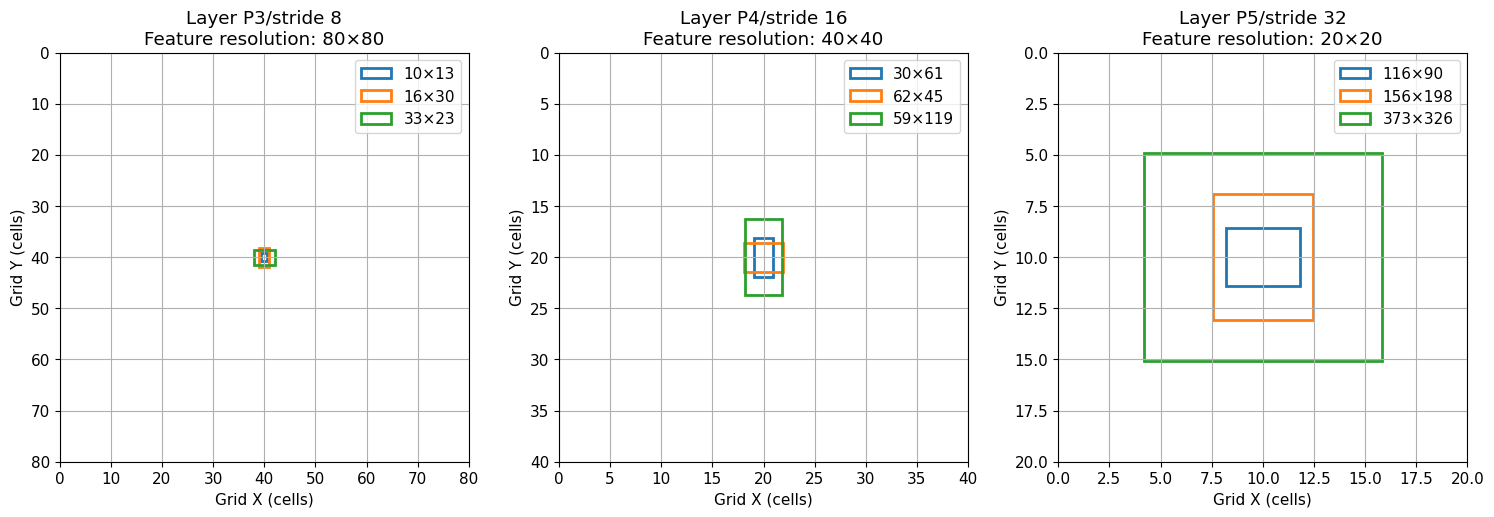

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# [TODO] Draw anchors

# Anchor definitions (pixel units) as per model config
anchor_defs = np.array([
    [10, 13, 16, 30, 33, 23],    # P3 / stride 8
    [30, 61, 62, 45, 59, 119],   # P4 / stride 16
    [116, 90, 156, 198, 373, 326]# P5 / stride 32
]).reshape(3, 3, 2)  # shape (3 layers, 3 anchors, [w, h])

# Get strides from model
strides = model.model[-1].stride.cpu().numpy()  # [8, 16, 32]

# Compute feature map sizes for input 640×640
input_size = 640
feat_shapes = [(input_size // int(s), input_size // int(s)) for s in strides]  # [(80,80),(40,40),(20,20)]

# Plot one subplot per layer
fig, axes = plt.subplots(1, len(strides), figsize=(5 * len(strides), 5))
for i, ax in enumerate(axes):
    ny, nx = feat_shapes[i]
    ax.set_xlim(0, nx)
    ax.set_ylim(ny, 0)  # invert y-axis
    ax.set_aspect('equal')
    ax.set_title(f'Layer P{i+3}/stride {int(strides[i])}\nFeature resolution: {ny}×{nx}')
    ax.set_xlabel('Grid X (cells)')
    ax.set_ylabel('Grid Y (cells)')
    ax.grid(True)

    # Center of grid
    cx, cy = nx / 2, ny / 2

    # Draw anchor rectangles (pixel sizes) at center cell
    for j in range(anchor_defs.shape[1]):
        w_px, h_px = anchor_defs[i, j]
        # Convert pixel units to cell units by dividing by stride
        w_cell, h_cell = w_px / strides[i], h_px / strides[i]
        rect = Rectangle(
            (cx - w_cell / 2, cy - h_cell / 2),  # (x, y) of top-left in cell coords
            w_cell, h_cell,
            edgecolor=f'C{j}', facecolor='none', lw=2,
            label=f'{w_px}×{h_px}'
        )
        ax.add_patch(rect)

    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# [TODO] Draw anchors

# Anchor definitions (pixel units) as per model config
anchor_defs = np.array([
    [8, 32, 12, 48, 16, 64],       # P3 / stride 8
    [16, 64, 24, 96, 32, 128],     # P4 / stride 16
    [32, 128, 48, 192, 64, 256]    # P5 / stride 32
]).reshape(3, 3, 2)  # shape (3 layers, 3 anchors, [w, h])

# Get strides from model
strides = model.model[-1].stride.cpu().numpy()  # [8, 16, 32]

# Compute feature map sizes for input 640×640
input_size = 640
feat_shapes = [(input_size // int(s), input_size // int(s)) for s in strides]  # [(80,80),(40,40),(20,20)]

# Plot one subplot per layer
fig, axes = plt.subplots(1, len(strides), figsize=(5 * len(strides), 5))
for i, ax in enumerate(axes):
    ny, nx = feat_shapes[i]
    ax.set_xlim(0, nx)
    ax.set_ylim(ny, 0)  # invert y-axis
    ax.set_aspect('equal')
    ax.set_title(f'Layer P{i+3}/stride {int(strides[i])}\nFeature resolution: {ny}×{nx}')
    ax.set_xlabel('Grid X (cells)')
    ax.set_ylabel('Grid Y (cells)')
    ax.grid(True)

    # Center of grid
    cx, cy = nx / 2, ny / 2

    # Draw anchor rectangles (pixel sizes) at center cell
    for j in range(anchor_defs.shape[1]):
        w_px, h_px = anchor_defs[i, j]
        # Convert pixel units to cell units by dividing by stride
        w_cell, h_cell = w_px / strides[i], h_px / strides[i]
        rect = Rectangle(
            (cx - w_cell / 2, cy - h_cell / 2),  # (x, y) of top-left in cell coords
            w_cell, h_cell,
            edgecolor=f'C{j}', facecolor='none', lw=2,
            label=f'{w_px}×{h_px}'
        )
        ax.add_patch(rect)

    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

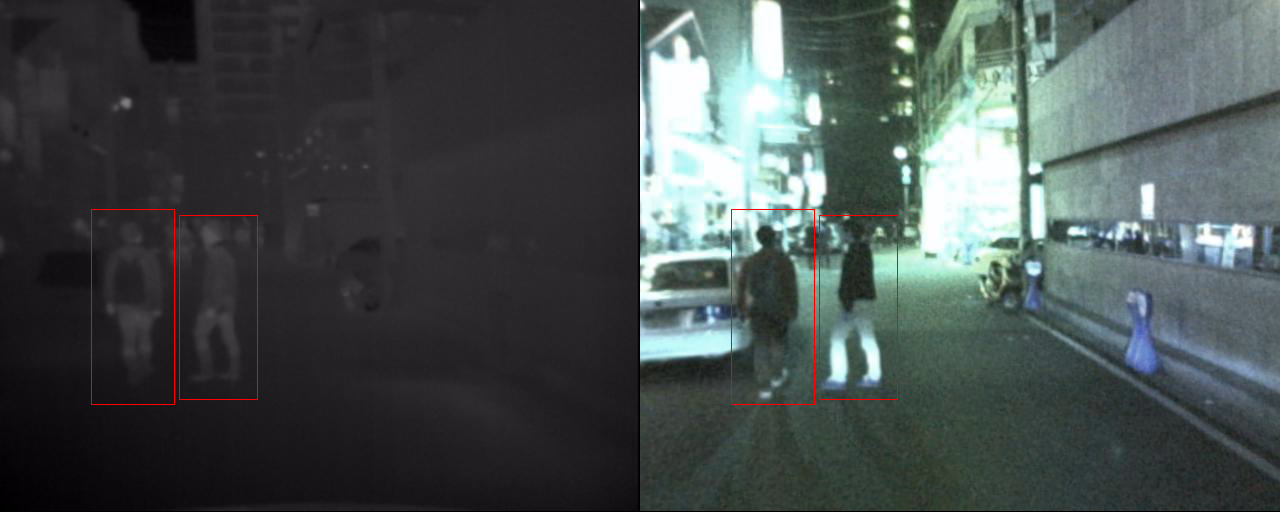

In [4]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [5]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=True,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=1,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


albumentations: 1 validation error for InitSchema
size
  Field required [type=missing, input_value={'scale': (0.8, 1.0), 'ra...: None, 'strict': False}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
train: Scanning /data2/test/AUE8088/datasets/kaist-rgbt/train-all-04... 408 images, 284 backgrounds, 0 corrupt:   3%|▎         | 408/12538 [00:00<00:06, 1849.51it/s]

train: Scanning /data2/test/AUE8088/datasets/kaist-rgbt/train-all-04... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:08<00:00, 1562.29it/s]
train: New cache created: /data2/test/AUE8088/datasets/kaist-rgbt/train-all-04.cache
albumentations_pair: RGB-only: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)), RandomBrightnessContrast(p=0.2, brightness_by_max=True, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), ensure_safe_range=False), RandomGamma(p=0.2, gamma_limit=(80.0, 120.0)), ImageCompression(p=0.01, compression_type='jpeg', quality_range=(99, 100))
albumentations_pair: LWIR-only: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), GaussNoise(p=0.05, mean_range=(0.0, 0.0), noise_scale_factor=1.0, per_channel=True, std_range=(0.2, 0.44))


datasets/kaist-rgbt/train/images/{}/set05_V000_I01219.jpg


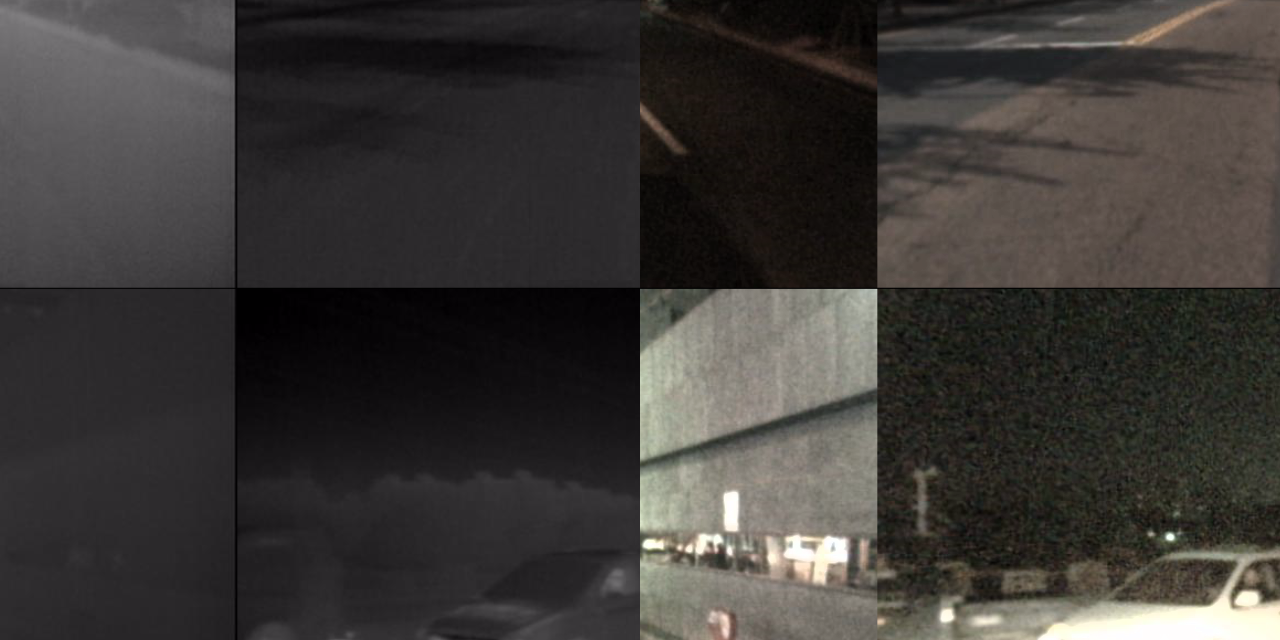

In [6]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 12112

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

In [7]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=1,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)

train: Scanning /data2/test/AUE8088/datasets/kaist-rgbt/train-all-04... 472 images, 304 backgrounds, 0 corrupt:   4%|▍         | 472/12538 [00:00<00:10, 1154.34it/s]

train: Scanning /data2/test/AUE8088/datasets/kaist-rgbt/train-all-04... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:08<00:00, 1547.99it/s]
train: New cache created: /data2/test/AUE8088/datasets/kaist-rgbt/train-all-04.cache


datasets/kaist-rgbt/train/images/{}/set05_V000_I01219.jpg


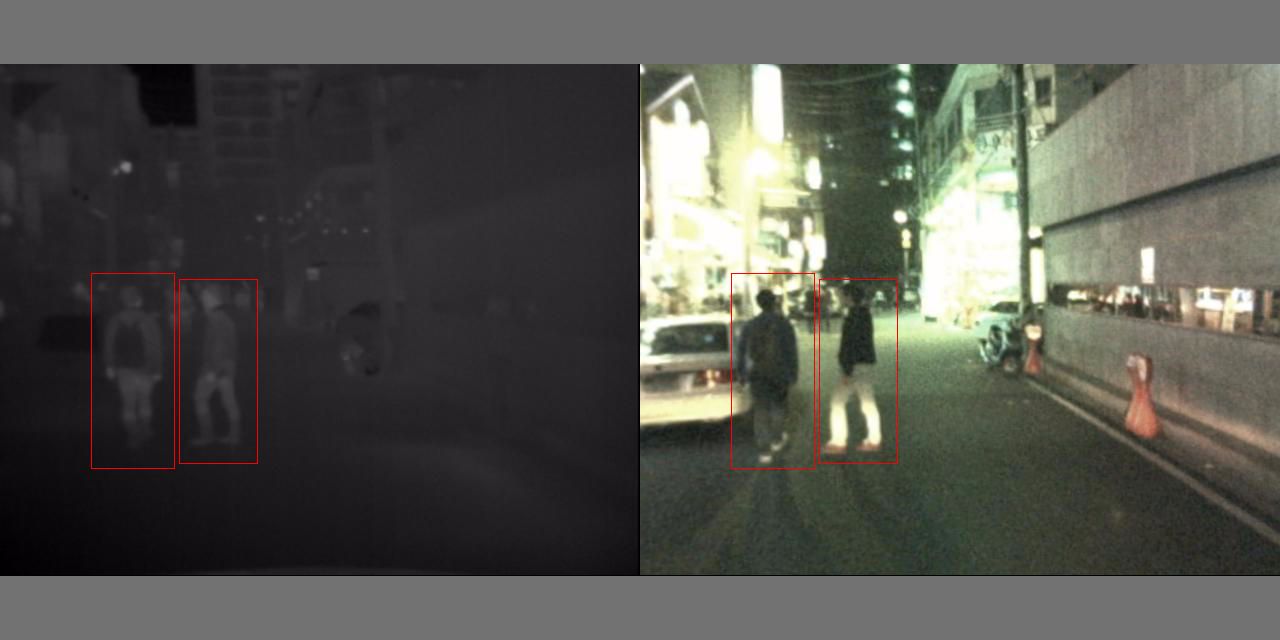

In [8]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 12112

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

## Run trained model
- Visualize bounding boxes from dataset class

In [9]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = 'runs/train/20250608_084615_yolov5n-rgbt-baseline-mosaic-mixup0.40-fliplr-e50/weights/last.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5n_kaist-rgbt.yaml'
# cfg = 'models/yolov5n_kaist-rgbt-xlarge-anchor-v2.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create
model.load_state_dict(torch.load(weights, map_location=device)['model'].state_dict()) # IMPORTANT: load state_dict from the checkpoint

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

YOLOv5 🚀 bddaf3c Python-3.10.18 torch-2.5.1+cu118 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3,

YOLOv5n_kaist-rgbt summary: 248 layers, 1840118 parameters, 1840118 gradients



In [29]:
# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward -> [xyxy, conf, cls]

[tensor([[9.17232e+01, 2.77552e+02, 1.72762e+02, 4.74212e+02, 8.62593e-01, 0.00000e+00],
        [1.76695e+02, 2.77641e+02, 2.49618e+02, 4.64951e+02, 8.05872e-01, 0.00000e+00],
        [1.68393e+02, 2.79158e+02, 1.98187e+02, 3.36170e+02, 3.50775e-01, 0.00000e+00],
        [1.57709e+02, 2.80644e+02, 1.86140e+02, 3.33047e+02, 2.55096e-01, 0.00000e+00]])]


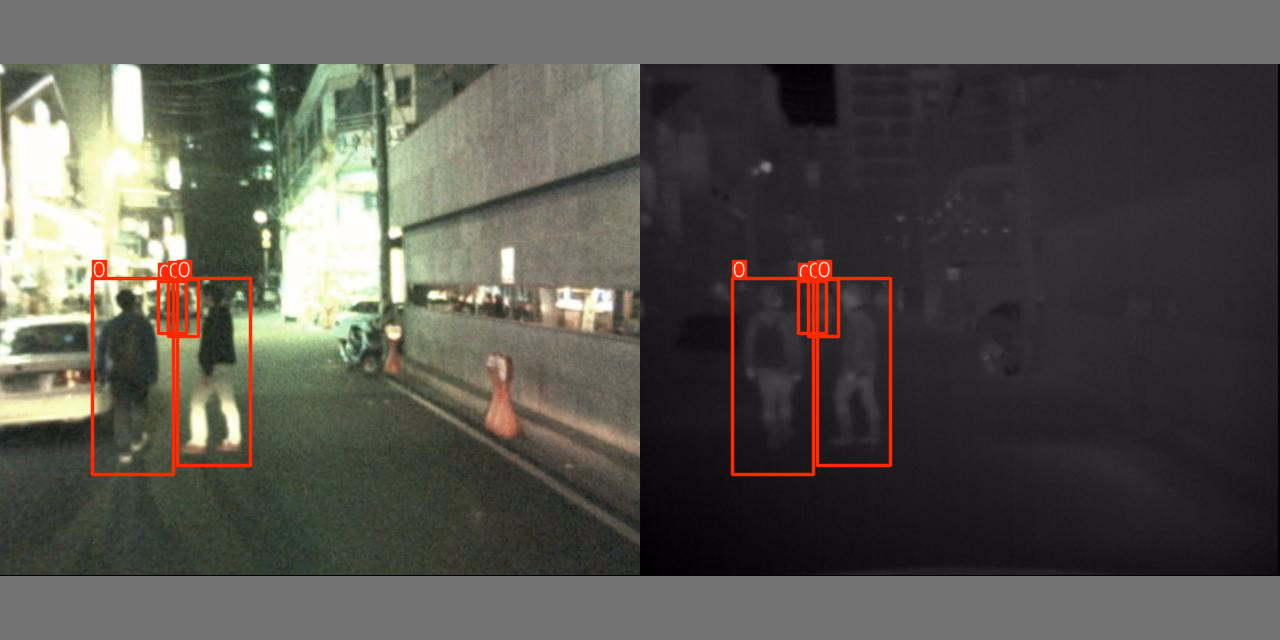

In [31]:
from utils.general import scale_boxes, non_max_suppression
from detect import Annotator, colors

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS
names = model.names

# Visualization
hide_conf = False
line_thickness = 2

dets = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
print(dets)

for i, det in enumerate(dets):
    if len(det):
        img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
        img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
        img_lwir = np.ascontiguousarray(img_lwir)
        img_vis = np.ascontiguousarray(img_vis)

        annotator_lwir = Annotator(img_vis, line_width=line_thickness, example=str(names))
        annotator_vis = Annotator(img_lwir, line_width=line_thickness, example=str(names))

        # Resize predicted box
        det[:, :4] = scale_boxes(img_vis.shape[:2], det[:, :4], shapes[0][0]).round()         # see valpy:L285

        # [TODO] draw predictions (see detect.py:L178)
        if len(det):
            # Print results
            for c in det[:, 5].unique():
                n = (det[:, 5] == c).sum()  # detections per class

            # Write results
            for *xyxy, conf, cls in reversed(det):
                c = int(cls)  # integer class
                label = names[c] if hide_conf else f"{names[c]}"
                annotator_lwir.box_label(xyxy, label, color=colors(c, True))
                annotator_vis.box_label(xyxy, label, color=colors(c, True))


results_lwir = annotator_lwir.result()
results_vis = annotator_vis.result()
results = np.concatenate([results_lwir, results_vis], axis=1)
Image.fromarray(results)